# Assignment 3

**Assignment 3: Evolutionary Algorithms**

**Goal**: Get familiar with evolutionary algorithms by implementing it and applying it to a given non-differentiable optimization task.

In this assignment, we are going to learn about evolutionary algorithms (EAs). The goal is to implement components of an evolutionary algorithm: a recombination operator, a mutation operator, and selection mechanisms, and analyze their behavior. This assignment is open to any choice of the aforementioned components​ as long as they are well motivated.

We are interested in optimizing a given **black-box** function that could be queried (i.e., it returns a value of the objective for given input values), but the gradient wrt the input cannot be calculated. The input to the system is a vector:
$$\mathbf{x} =[\alpha_0, n, \beta, \alpha]^{\top} \in [−2,10] \times [0,10] \times [−5,20] \times [500,2500]. $$

The optimized function is based on the gene repressilator model. For details, please see Section 4.2 in <a href='https://arxiv.org/abs/2002.02869' target='_blank'>HERE</a>.

## 1. Understanding the problem

The considered problem is about finding parameter values of a model widely used in biology, namely, the gene repressilator model. This model represents a simple network in which a gene (mRNA) is produced by a protein, and then this gene is used to produce another protein. Altogether, there are 3 genes and 3 proteins that are connected as follows: $m_1 \rightarrow p_1$, $p_1 \rightarrow m_2$, $m_2 \rightarrow p_2$, $p_2 \rightarrow m_3$, $m_3 \rightarrow p_3$, $p_3 \rightarrow m_1$.

Please run the code below and spend a while on analyzing the signals in the model. Think of the osscilatory character of the signals.

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [ ]:
import copy
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

EPS = 1.0e-7

In [ ]:
# PLEASE DO NOT REMOVE!
# This is the main class for the gene repressilator model.
# There is no need to understand how it works! You can treat it as a black-box.
# It is important to realize that we can always ask this object to give us
# an evaluation of given parameter values.
class Repressilator(object):
    def __init__(self, y_real, params):
        super().__init__()
        self.y_real = y_real.copy()
        self.params = params.copy()

    # The definition of the gene repressilator model as a system of ODEs.
    def repressilator_model(self, t, y):
        m1, m2, m3, p1, p2, p3 = y[0], y[1], y[2], y[3], y[4], y[5]

        alpha0 = self.params["alpha0"]
        n = self.params["n"]
        beta = self.params["beta"]
        alpha = self.params["alpha"]

        dm1_dt = -m1 + alpha / (1.0 + p3**n) + alpha0
        dp1_dt = -beta * (p1 - m1)
        dm2_dt = -m2 + alpha / (1.0 + p1**n) + alpha0
        dp2_dt = -beta * (p2 - m2)
        dm3_dt = -m3 + alpha / (1.0 + p2**n) + alpha0
        dp3_dt = -beta * (p3 - m3)

        return dm1_dt, dm2_dt, dm3_dt, dp1_dt, dp2_dt, dp3_dt

    # A numerial solver for the model (here we use Runge-Kutta 4.5)
    def solve_repressilator(self):
        # we need to use lambda function if we want to pass some parameters
        solution = solve_ivp(
            lambda t, y: self.repressilator_model(t, y),
            t_span=(self.params["t0"], self.params["t1"]),
            y0=self.params["y0"],
            method="RK45",
            t_eval=self.params["t_points"],
        )
        y_points = np.asarray(solution.y)
        return self.params["t_points"], y_points

    # An auxiliary function: setting parameters.
    def set_params(self, x):
        self.params["alpha0"] = x[0]
        self.params["n"] = x[1]
        self.params["beta"] = x[2]
        self.params["alpha"] = x[3]

    # Calculating the objective function.
    # Here, we use the Euclidean distance between the real data and the synthetic data.
    @staticmethod
    def loss(y_real, y_model):
        # we assume only m's are observed!
        y_r = y_real[0:3]
        y_m = y_model[0:3]
        if y_r.shape[1] == y_m.shape[1]:
            return np.mean(np.sqrt(np.sum((y_r - y_m) ** 2, 0)))
        else:
            return np.infty

    # objective function would return a list of real value for each solution (set of weights) 1D
    def objective(self, x):
        if len(x.shape) > 1:
            objective_values = []
            for i in range(x.shape[0]):
                xi = x[i]
                self.set_params(xi)

                _, y_model = self.solve_repressilator()
                objective_values.append(self.loss(self.y_real, y_model))

            objective_values = np.asarray(objective_values)
        else:
            self.set_params(x)

            _, y_model = self.solve_repressilator()
            objective_values = self.loss(self.y_real, y_model)

        return objective_values

In [ ]:
# PLEASE DO NOT REMOVE!
# Initialize the problem.
# Here we set the real parameters and generate "real" data. To make the problem
# more realistic, we add a small Gaussian noise.
params = {}
params["alpha0"] = 1.1
params["n"] = 2.9
params["beta"] = 5.5
params["alpha"] = 500
params["t0"] = 0.0
params["t1"] = 60.5
params["t_points"] = np.arange(0, 60, 0.5)
params["x0"] = np.asarray([[5.64167522, 2.07180539, 3.56690274, 7.0015145]])
params["y0"] = np.asarray([0.0, 0.0, 0.0, 2.0, 1.0, 3.0])

# Generate "real" data
r = Repressilator([0], params)
_, y_real = r.solve_repressilator()
del r  # we remove the object, just in case
y_real = y_real + np.random.randn(*y_real.shape) * 5.0  # add noise!

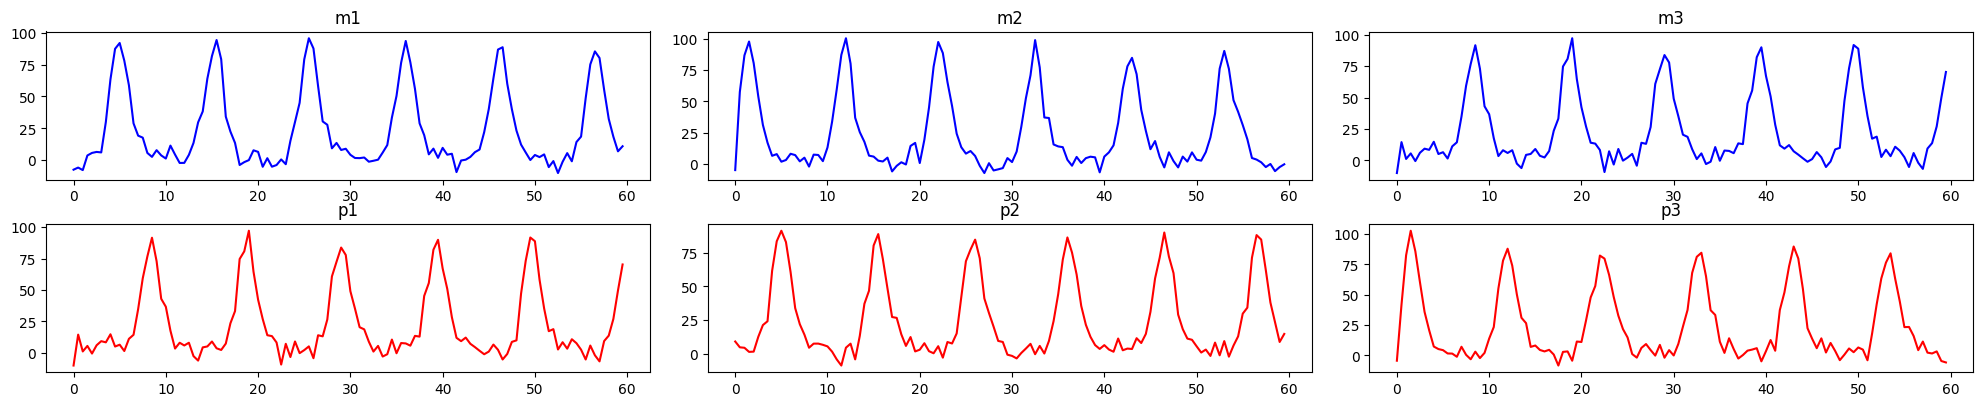

In [ ]:
# PLEASE DO NOT REMOVE
# Here, we plot all signals in the model.
# Note that later on, we assume that only gene expression (i.e., m1, m2, m3)
# are observed (blue plots) and proteins (i.e. p1, p2, p3) are unobserved (in red).
t = params["t_points"]

fig_data, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_data.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
        else:
            title = "p"
            color = "r"

        axs[i, j].plot(t, y_real[2 * i + j], color)
        axs[i, j].set_title(title + str(j + 1))

## 2. Evolutionary Algorithms

In this assignment, you are asked to implement an evolutionary algorithm (EA). Please take a look at the class below and fill in the missing parts. Please keep in mind that you are free to choose any operations as lons as they are appropriate for evolutionary algorithms.

NOTE: Please pay attention to the inputs and outputs of each function.

**Question 1 (0-0.5pt):** Do you use a mutation operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:** The mutation operator for the continuous representation would be ultilized is random pertubation on a particular gene of the chromosome. Here, I defined the gene to implement mutation is the last gene in a chromosome. First, a value (y) would be randomly sampled from the uniform distribution within the given bound of that gene. Then the perturbed version (x') would equal to the old value (x) plus the drawn value (y).

**Question 2 (0-0.5pt):** Do you use a cross-over operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
The recombination executed in the Evolutionary Algorithms is one-point crossover. The cross-over point is established as the mid point in one solution. Then, for each child, 2 parents are mated and the first half body of the child would inherent the first half body of the first parent and the second half is derived from the second half of the second parent.

**Question 3 (0-0.5pt):** What kind of selection mechanism do you use? Please explain in detail and motivation your choice.

**Answer:**
The selection mechanism used is tournament selection. First, the number of individuals k for each tournmant is set to 10. Second, k random solutions are drawn from the combined population between old parents and offsprigs. Then, the best one (who has the highest linear ranking probability) is gained and moved to the mating pool. Repeat the process until the number of individuals is qualified.

**Question 4 (0-0.5pt):** Do you use any other operation? If yes, please explain and motivate your choice.

**Answer:**
In parent selection, the order of parents is ranked based on their fitness values. The method would be used is the linear ranking:
$$\mathbf{p_{i}} = {1 \over n }(sp - (2sp -2){(rank_{i}-1) \over (n-1)}$$
where $ sp ∈ [1,2]$.

The higher the sp is, the more pressure on the dominant value is. Morever, the best one who possess the lowest fitness value and the lowest rank would have the highest linear ranking probability. The slope of the ranker(sp) is set to 1.5 to decline the high pressure for the solution whose fitness value is so high. 

Additionally, the survivor selection would occur by merging both the old set of parents and the new offsprings. The first pop_sixe(100) individuals would be set as the new population for the next round.

**Question 5 (0-0.5-1pt):** Please provide a pseudo-code for your evolutionary algorithm. Please try to be as formal as possible!

**Answer:**

1. Randomly initialize a population with 100 individuals based on the uniform distribution with the specified bounds for each gene
2. For each individual $x_i$ find f($x_i$) = $fitness_i$
3. Repeat until the new population is found

  a) Select the opitmal set of 50 parents based on the parent selection method

  b) Apply one-point crossover on the set of parents to create the new set of off-spring 

  c) Implement uniform mutation on the set of offsprings

  d) Merge both sets of old parents and offspring together

  e) Evaluate on the combined set and choose the best 100 individuals based on their fitness values.

In [ ]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but some functions are incorrect and it is badly explained
# 1.0 pt if code works but some functions are incorrect
# 2.0 pt if code works but it does not correspond to the description above and it is badly explained
# 2.5 pt if code works and it is well explained, but it does not correspond to the description above
# 3.0 pt if code works and it is aligned with the description about, but it is badly explained
# 3.5 pt if code works and it is aligned with the description about, and it is well explained
# 4.0 pt if code works, it is as it was described, it is well explained, and the proposed operations are beyond the lecture!
# =========
# Implement the Evolutionary Algorithm (EA) algorithm.
# It is equivalent to implementing the step function.
class EA(object):
    def __init__(self, repressilator, pop_size, bounds_min=None, bounds_max=None):
        self.repressilator = repressilator
        self.pop_size = pop_size
        self.bounds_min = bounds_min
        self.bounds_max = bounds_max
        # -------
        # all necessary hyperparameters come here
        # the number of parents would account for half of the population
        self.num_parents_mating = self.pop_size // 2 
        # -------

    # -------
    # PLEASE FILL IN
    # all necessary operations (e.g., mutation, selection) must come here.
    # -------


    # function would return the linear ranking probability of each individual 
    # the slope is negative so
    # the best one has the high probability and rank is 1
    def linear_ranking_pro(self,rank):
        sp = 1.5 # hyperparameter of the linear ranking function
        # return the probability after the linear ranking function
        return (1/self.pop_size)*(sp - (2*sp - 2)*(rank+1-1)/(self.pop_size-1))
    
    # function would return a set of potential parents for mating
    def parent_selection(self, x_old, f_old):
        # create an empty array to contain the mating parents
        x_parents = np.empty((self.num_parents_mating, x_old.shape[1]))
        f_parents = np.empty(self.num_parents_mating) # their corresponding fitnesses
        # sort the individuals based on its fitness value
        sorted_x = np.array([x for x,_ in sorted(zip(x_old,f_old), key = lambda pair: pair[1])])
        # an array to contain the linear ranking probability
        pop_pro = np.empty(self.pop_size)
        for rank in range(sorted_x.shape[0]):
            # append the individual probability based on linear ranking
            pop_pro[rank] = self.linear_ranking_pro(rank)

        # set k random parents for each tournament selection
        k = 10
        # implement tournament selection
        for parent in range(self.num_parents_mating):
            random_indices = np.random.choice(self.pop_size, k, replace = False) # choose 5 random indices
            random_parents = [x_old[index] for index in random_indices] # retrieve these parents
            fitness = [pop_pro[index] for index in random_indices] # define fitness as the linear ranking probability
            best_ind = np.argmax(fitness) # choose the one whose fitness is highest 
            x_parents[parent] = random_parents[best_ind] # add the best parent to the mating pool
            f_parents[parent] = self.evaluate(x_parents[parent]) # also return his/her evaluation
        return x_parents, f_parents

    # function would implement the onr-point crossover between parents
    def recombination(self, x_parents, f_parents):
        # create an empty array for children
        x_children = np.empty(x_parents.shape)
        # define cross-over point
        crossoverPoint = np.uint8(x_children.shape[1]/2)

        for child in range(x_children.shape[0]):
            # index of first and second parents
            parentIndex1 = child % x_parents.shape[0]
            parentIndex2 = (child+1) % x_parents.shape[0]

            # the sequence of genes in the child would equal to
            # the first half strusture of the first parent combined with
            # the second half of the second parent
            x_children[child,0:crossoverPoint] = x_parents[parentIndex1,0:crossoverPoint]
            x_children[child,crossoverPoint:] = x_parents[parentIndex2,crossoverPoint:]
        return x_children

    # function would exeute the uniform mutation over one specified gene
    def mutation(self, x_children):
        # mutation would change a specified gene in a child
        # by a uniform ditribution 
        gene_index = 3 # specify the gene

        for child in range(x_children.shape[0]):
            # sample a random value from unifrom distribution with the defined bound
            random_value = np.random.uniform(self.bounds_min[gene_index], self.bounds_max[gene_index], 1)
            # the new value of the gene would equal to the old value plused by the random value
            x_children[child, gene_index] += random_value  
        return x_children

    # function would merge parents and offsprings together
    # then find the best pop_size individuals to constitute a new population
    def survivor_selection(self, x_old, x_children, f_old, f_children):
        # create empty arrays for last solutions 
        x = np.empty((self.pop_size, x_old.shape[1]))
        f = np.empty(self.pop_size)
        # merge old parents and offsprings
        combine_x = np.concatenate([x_old, x_children]) # weights
        combine_f = np.concatenate([f_old, f_children]) # their fitness
        # in 100 iterations
        for ind in range(self.pop_size):
            # pick index of the best parents
            best_parent_ind = np.argmin(combine_f) # fitness is min
            x[ind] = combine_x[best_parent_ind] # retrieve solution
            f[ind] = combine_f[best_parent_ind] # retrieve its evalution
            # set the evaluation to inf to avoid it in the next round
            combine_f[best_parent_ind] = np.inf 
        
        return x, f

    def evaluate(self, x):
        return self.repressilator.objective(x)

    def step(self, x_old, f_old):
        # -------
        # PLEASE FILL IN
        # NOTE: This function must return x, f
        # where x - population
        #       f - fitness values of the population
        # -------

        x_parents, f_parents = self.parent_selection(x_old, f_old)

        x_children = self.recombination(x_parents, f_parents)

        x_children = self.mutation(x_children)

        f_children = self.evaluate(x_children)

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

        return x, f

**NOTE 1**

Since this assignment allows you implementing your own operations, this is difficult to prepare a code for that. Therefore, please use the code below to find the best set of your hyperparameters in a separate file, and then present your analysis for the best valyes of the hyperparameters here.

**NOTE 2**

Additionally, please do try various population sizes (25, 50, 100, ...). You will be asked about it later.

In [ ]:
# PLEASE DO NOT REMOVE!
num_generations = 50  # if necessary, please increase the number of generations
pop_size = 100
bounds_min = [-2.0, 0.0, -5.0, 0.0]
bounds_max = [10.0, 10.0, 20.0, 2500.0]
# -------
# PLEASE FILL IN!
# Your hyperparams go here.
# PLEASE USE THE VALUES OF THE HYPERPARAMETERS FOR WHICH YOU OBTAINED THE BEST RESULTS.
# DO NOT ITERATE OVER THEM!
# -------

# Initialize the repressilator
repressilator = Repressilator(y_real, params)

# -------
# PLEASE FILL IN!
# Your object goes here:
ea = EA(repressilator, pop_size, bounds_min, bounds_max)
# -------

# Init the population
x = np.random.uniform(low=bounds_min, high=bounds_max, size=(pop_size, 4))
f = ea.evaluate(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
# the best candidate is one whose evaluation is the lowest 
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0:
        print("Generation: {}, best fitness: {:.2f}".format(i, f.min()))
    # x is the initial population
    # f is the evaluation of the population
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
    else:
        f_best.append(f_best[-1])
print("FINISHED!")

<ipython-input-2-5644a3411d71>:21: RuntimeWarning: invalid value encountered in double_scalars
  dm1_dt = -m1 + alpha / (1.0 + p3**n) + alpha0
<ipython-input-2-5644a3411d71>:23: RuntimeWarning: invalid value encountered in double_scalars
  dm2_dt = -m2 + alpha / (1.0 + p1**n) + alpha0
<ipython-input-2-5644a3411d71>:25: RuntimeWarning: invalid value encountered in double_scalars
  dm3_dt = -m3 + alpha / (1.0 + p2**n) + alpha0


Generation: 0, best fitness: 30.92
Generation: 5, best fitness: 30.92
Generation: 10, best fitness: 24.45
Generation: 15, best fitness: 23.77
Generation: 20, best fitness: 23.77
Generation: 25, best fitness: 23.77
Generation: 30, best fitness: 23.77
Generation: 35, best fitness: 23.77
Generation: 40, best fitness: 23.73
Generation: 45, best fitness: 23.73
FINISHED!


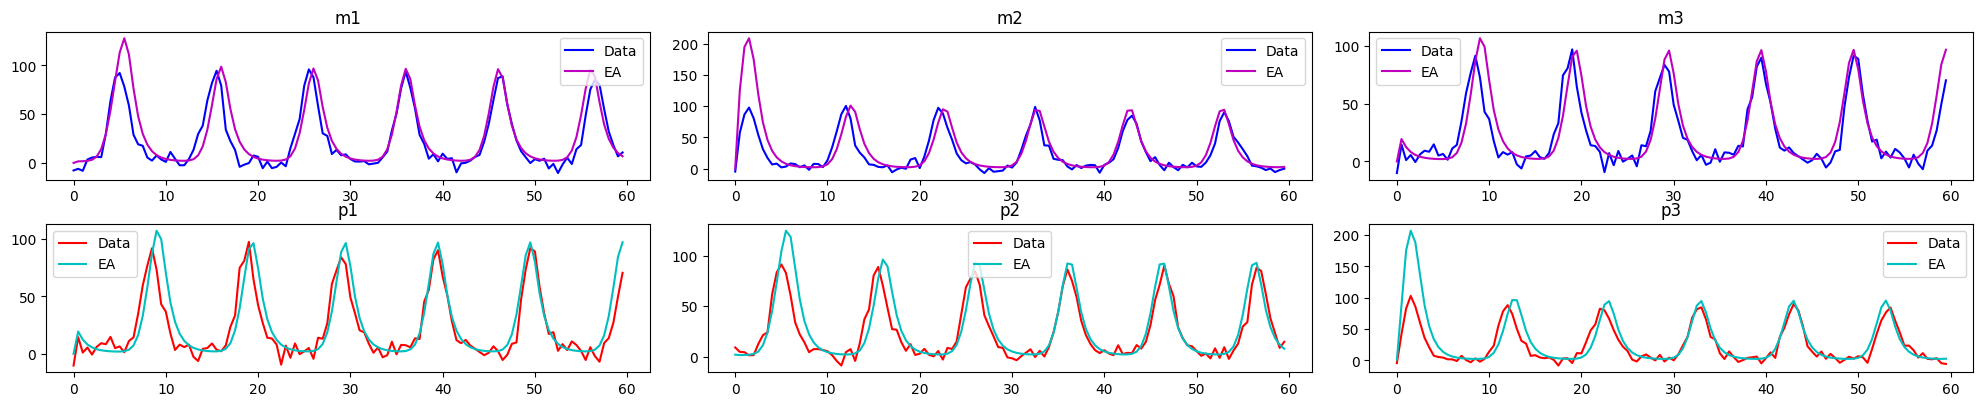

In [ ]:
# PLEASE DO NOT REMOVE
# Generate signals for the best performing parameter values
repressilator.set_params(
    x[f.argmin()],
)
t, y_best = repressilator.solve_repressilator()

# Create plots
fig_ea, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_ea.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
            color_m = "m"
        else:
            title = "p"
            color = "r"
            color_m = "c"

        axs[i, j].plot(t, y_real[2 * i + j], color, label="Data")
        axs[i, j].plot(t, y_best[2 * i + j], color_m, label="EA")
        axs[i, j].set_title(title + str(j + 1))
        axs[i, j].legend()

Text(0.5, 1.0, '$n$ vs. $\\beta$')

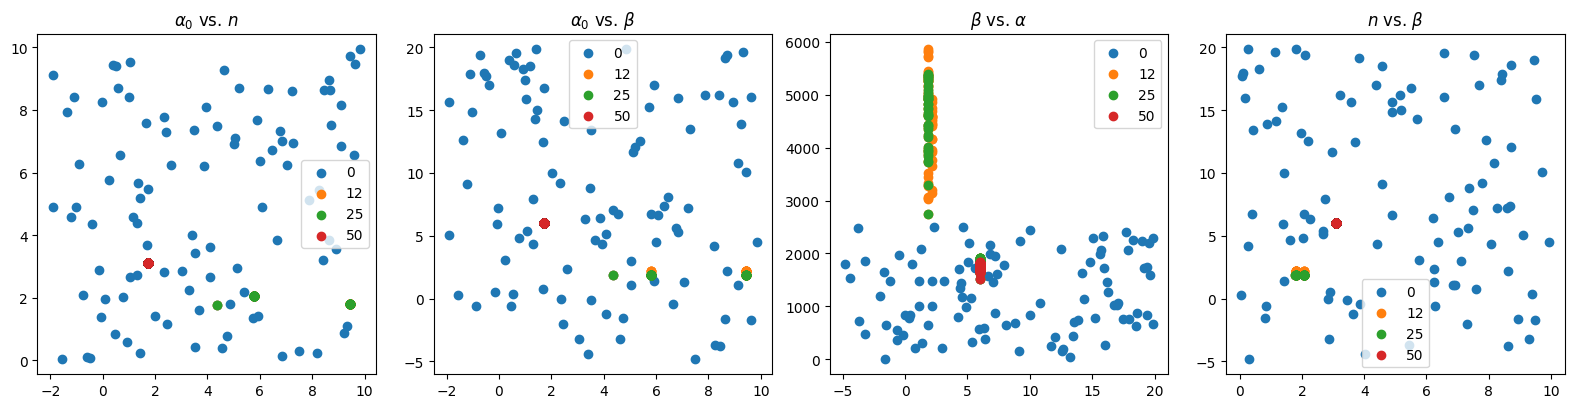

In [ ]:
# PLEASE DO NOT REMOVE
# Generate scatterplots for the populations
gens = [0,num_generations // 4, num_generations // 2, num_generations]
fig_ea_pops, axs = plt.subplots(1, 4, figsize=(16, 4))
fig_ea_pops.tight_layout()


for i in range(len(gens)):
    pop_i = populations[gens[i]]
    axs[0].scatter(pop_i[:, 0], pop_i[:, 1], label=str(gens[i]))
    axs[1].scatter(pop_i[:, 0], pop_i[:, 2], label=str(gens[i]))
    axs[2].scatter(pop_i[:, 2], pop_i[:, 3], label=str(gens[i]))
    axs[3].scatter(pop_i[:, 1], pop_i[:, 2], label=str(gens[i]))
axs[0].legend(), axs[1].legend(), axs[2].legend(), axs[3].legend()
axs[0].set_title(r"$\alpha_0$ vs. $n$")
axs[1].set_title(r"$\alpha_0$ vs. $\beta$")
axs[2].set_title(r"$\beta$ vs. $\alpha$")
axs[3].set_title(r"$n$ vs. $\beta$")

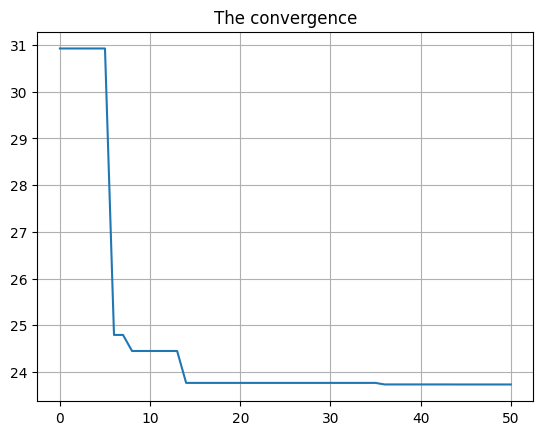

In [ ]:
# PLEASE DO NOT REMOVE
# The convergence plot: the best value of the fitness function for each generation
plt.plot(range(len(f_best)), f_best)
plt.title("The convergence")
plt.grid()

## 4. Final remarks: Analysis

Eventually, please answer the following last questions that will allow you to conclude the assignment.

**Question 6 (0-0.5pt)**: After analyzing the results, do you think your algorithm discovered the real values of the parameters? Why? Please indicate which plots indicate that? If not, what is a potential explanation?

**Answer**: My algorithm, at some extent, did not discorvered the real values of the paramenters. First, the benefit values did converge to 23,73 while the expected value is 0. Second, by inspecting the line graphs, it is obviously seen that the solution of my Evolutionary Algorithm (EA) is fairly comparable to the data, but not absolutely. If we have a thoroughful look at the line graph, the first peaks of all the relations does not match with the real hill. Besides, the model overlooked the fluctuation of all the valeys and tried to smoothen them. It is somehow impossible to match the data 100 percent but at least the peaks of the EA solution is generally as high as those of the dataset and the range of is not moved much far or less exteneded from the original. One thing is that the solution is slightly shifted to the right of the data.

**Question 7 (0-0.5pt)**: How the population influences the performance of evolutionary algorithms? What population sizes did you use?

**Answer**: If the population is set too small (25 individuals), the EA would converge really fast and vulnerable to the adversable local optimum. Contrastingly, if ther are 200 individuals in a population, the computation will be very costly but it guarantees the escape from severity of the dominant values and such mentioned local optimums.  

**Question 8 (0-0.5pt)**: What are the advantages of your approach?

**Answer**: By implementing the linear ranking in selection mechanism, the evolutionary algorithm can exclude the effect of premature converge. It lowers the order of dominant values by sorting the parents based on their benefit values (not the probability of being chosen by their total benefits). Thus, it leads to the invariance to the magnitude of the fitness value to broaden a possibility to choose the less crucial points for further step such as mutation and cross-over operations. It, somehow, creates a diversity for the next generation. 

**Question 9 (0-0.5pt)**: What are the drawbacks of your approach?

**Answer**: The remarable drawback is drawing the parents for pooling match with replacement. In spite of being used the random sampling method with ratio 1/10, there is still slightly biased towards the solutions having extremely large magnitude. Thus, it possibly bars the EA from conducting the exploration over the search space. 

**Question 10 (0-0.5pt)**: How could you improve convergence speed of your algorithm? Please provide very specific answer, ideally supported with literature and mathematical formulas.

**Answer**: To accelerate the converge speed, we substitute the random number generator (RNG) by the chaotic sequence in all phases of the EA where the random choice is neccessary. In the [paper](https://www.researchgate.net/profile/Mg-Xibilia/publication/3418746_Chaotic_sequences_to_improve_the_performance_of_evolutionary_algorithms/links/0fcfd50b8a3e8e970e000000/Chaotic-sequences-to-improve-the-performance-of-evolutionary-algorithms.pdf), R. Caponetto provided several chaotic dynamic systems but Sinusoidal iterator has the most superior performance over the random generator. The formular is given: 

$$\mathbf{x_{k+1}} = α \times x_{k}^{2} \times \sin(πx_{k}) . $$

where a and $x_{0}$ are hyperparameters.

In the experiment, the initial value of the (RGN) $x_{0} =  0$ and that figure of Sinusoidal iterator is $x_{0} = 0.7$ and $\alpha = 2.3$. The outcome would be depicted in Figure 6:
![any name](https://drive.google.com/uc?export=view&id=1rdl7B3iUPU215o-z2wa3rb07MKETisYR)

From the results indicated by the paper, it is believed that if we initialize the population or sample a random number by the chaotic dynatic system with Sinusoidal iterator, the number of generation used for the EA would be declined significantly. Consequently, the burdern of computational cost would be dropped.  





**Question 11 (0-0.5pt)**: How does an EA compares with the Metropolis-Hastings algorithm? What are the similarities? What are the differences?

**Answer**: In general, both algorithms are finding the optimal solution by targeting the objective function. More specifically, they only approve the new solution if it has less or equal loss to the objective function than the current solution. Otherwise, they would generate the new set of solutions. Definitely, the inner mechianisms are significant different but they mutually give us a control over the exploration and exploitation trade-off. However, Metropolis-Hasting explores its search space with only one individual wheares Evolutionary Agorithm starts with a set of population. Besides, the next generation of MH is sampled by the proposal distribution with the current point as the mean and the variance is a hyperparameter while the new solution of EA is a combination of execellent inviduals between the parents and the offsprings and the offsprings are created with many mating operators such as mutation and recombination which are not presented in the MH. 